In [227]:
import h5py as hp
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sbs
from aps_figures.aps_one_column import *
from SOLEILII_parameters.SOLEILII_TDR_parameters import *
N_SEGMENTS = 416
def read_bunch(bunch_number, n_macroparticles):
    # filename = '/home/gubaidulin/SOLEIL-II/Code/fbii_pyht_tracking/Results_sumo/BM_(n_bunch={0:}, n_macro={1:.1e}).h5'.format(int(bunch_number), n_macroparticles)
    # filename = '/home/gubaidulin/scripts/fbii_pyht_tracking/Results_sumo/BM_(n_bunch={0:}, n_macro={1:.1e}, n_macro_ions={2:.1e}).h5'.format(bunch_number, n_macroparticles, 1e4)
    filename = 'Results/BM_n={0:}.h5'.format(bunch_number)
    file = hp.File(filename)
    mean_x = file['Bunch']['mean_x'][:]
    sigma_x = file['Bunch']['sigma_x'][:]
    mean_xp = file['Bunch']['mean_xp'][:]
    mean_y = file['Bunch']['mean_y'][:]
    sigma_y = file['Bunch']['sigma_y'][:]
    mean_yp = file['Bunch']['mean_yp'][:]
    mean_z = file['Bunch']['mean_z'][:] 
    mean_dp = file['Bunch']['mean_dp'][:]
    file.close()
    return mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp
def read_ion_element(index):
    filename = 'Results/IM(ind={0:}).h5'.format(int(index))
    file = hp.File(filename)
    mean_x = file['Bunch']['mean_x'][:]
    sigma_x = file['Bunch']['sigma_x'][:]
    mean_xp = file['Bunch']['mean_xp'][:]
    mean_y = file['Bunch']['mean_y'][:]
    sigma_y = file['Bunch']['sigma_y'][:]
    mean_yp = file['Bunch']['mean_yp'][:]
    mean_z = file['Bunch']['mean_z'][:] 
    mean_dp = file['Bunch']['mean_dp'][:]
    file.close()
    return mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp
def read_ion_particles(index, step):
    filename = 'Results/IPM(ind={0:})3.h5part'.format(int(index))
    file = hp.File(filename)
    # for step in range(file['Step']['x'][:])
    
    mean_x = file['Step#{:}'.format(step)]['x'][:]
    mean_xp = file['Step#{:}'.format(step)]['xp'][:]
    mean_y = file['Step#{:}'.format(step)]['y'][:]
    mean_yp = file['Step#{:}'.format(step)]['yp'][:]
    mean_z = file['Step#{:}'.format(step)]['z'][:] 
    mean_dp = file['Step#{:}'.format(step)]['dp'][:]
    file.close()
    return mean_x, mean_xp, mean_y, mean_yp, mean_z, mean_dp

In [228]:
filename = 'Results/IPM(ind={0:}).h5part'.format(int(0))
file = hp.File(filename)
print(len(file.keys()))
file.close()

413


(2500,)


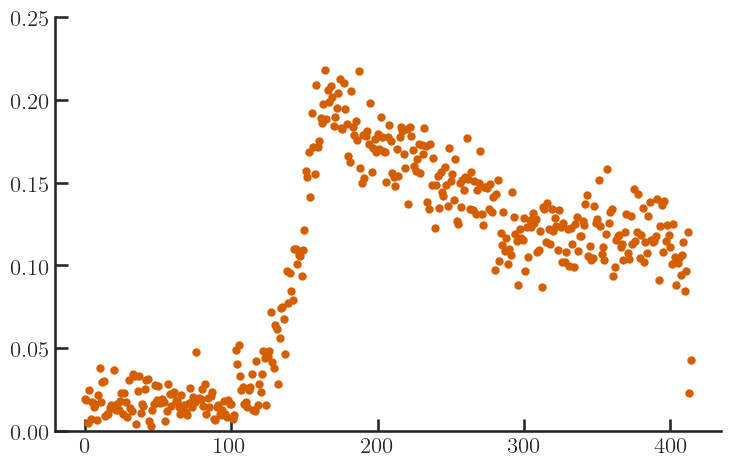

In [229]:
n_macroparticles = int(5e3)
fig, ax = plt.subplots(1, 1)
for bunch_number in range(415):
    mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(bunch_number, n_macroparticles)
    # ax.scatter(bunch_number, np.max(mean_x[-100:])/sigma_x[0], marker='.', color='b')
    ax.scatter(bunch_number, np.max(mean_y[:])/sigma_y[0], marker='.', color='r')
ax.set_ylim(0, .25)
# print(np.max(mean_y[-50:]))
print(mean_y.shape)

In [230]:
bunch_number = 300
n_macropartices = int(1e4)
mean_x, sigma_x, mean_xp, mean_y, sigma_y, mean_yp, mean_z, mean_dp = read_bunch(bunch_number, n_macroparticles)
print(mean_x.shape)
mean_x_ion, sigma_x_ion, mean_xp_ion, mean_y_ion, sigma_y_ion, mean_yp_ion, mean_z_ion, mean_dp_ion = read_ion_element(0)

(2500,)


12.977931286399556


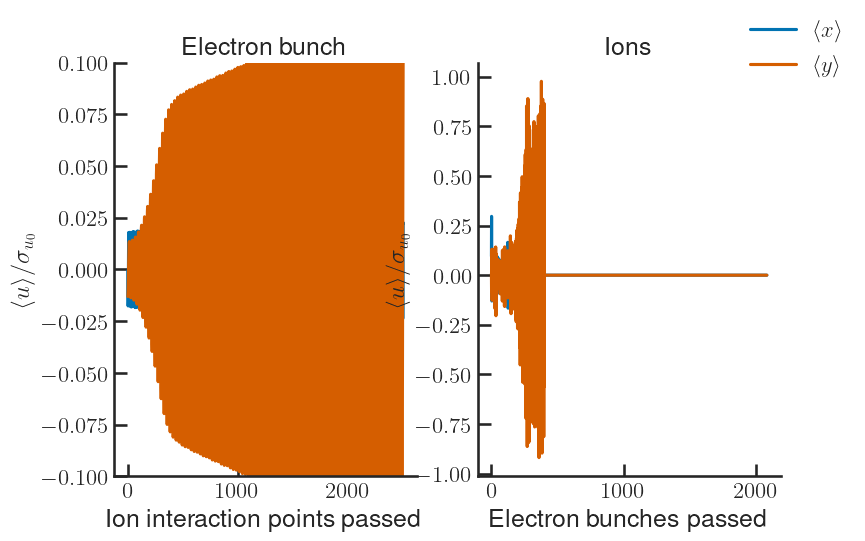

In [231]:
from FITX import fit_risetime
fig, (ax_el, ax_ions) = plt.subplots(1, 2)
for ax in (ax_el, ax_ions):
    ax.set_ylabel('$\langle u \\rangle/\sigma_{u_0}$')
ax_el.set_xlabel('Ion interaction points passed')
ax_ions.set_xlabel('Electron bunches passed')

    # ax.set_ylim(-.2, .2)
ax_ions.plot((mean_x_ion)/sigma_x[0], color='b', label='$\langle x \\rangle$')
ax_ions.plot((mean_y_ion)/sigma_y[0], color='r', label='$\langle y \\rangle$')
ax_el.plot(mean_x/sigma_x[0], color='b')
ax_el.plot(mean_y/sigma_y[0], color='r')
signal = np.sqrt(mean_y**2+(BETA_Y_SMOOTH*mean_yp)**2)/sigma_y[0]
rx = fit_risetime(signal, min_level=.1, 
        smoothing_window_size=5, 
                 matplotlib_axis = None)
print(rx/416)
ax_el.set_ylim(-.1, .1)
ax_ions.title.set_text('Ions')
ax_el.title.set_text('Electron bunch')
plt.figlegend(frameon=False)

Rms sizes of 1) electron distribution 9.98e-06, ion initial ion distribution 1.76e-05, equilibrium ion distribution 0.00e+00


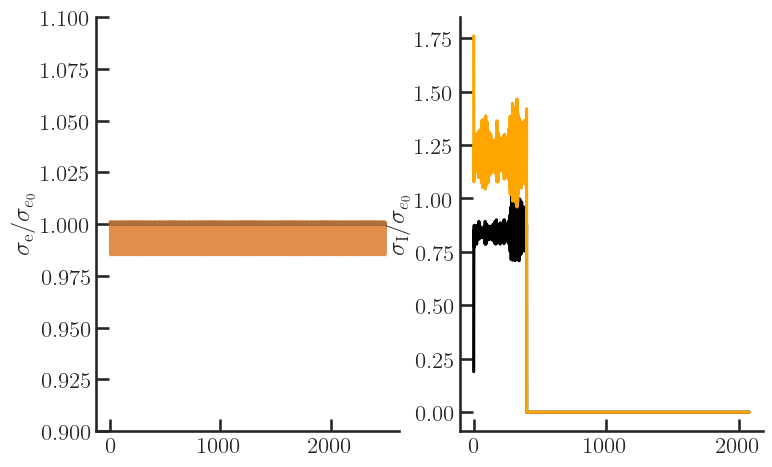

In [232]:
fig, (ax_el, ax_ions) = plt.subplots(1, 2)
ax_el.set_ylim(.9, 1.1)
# ax_ions.set_ylim(0.1, 1.5)
ax_el.plot(sigma_x/sigma_x[0], color='b', label='$\sigma_x$', alpha=0.7)
ax_el.plot(sigma_y/sigma_y[0], color='r', label='$\sigma_y$', alpha=0.7)
ax_ions.plot(sigma_x_ion/sigma_x[0], color='black', label='$\sigma_x$')
ax_ions.plot(sigma_y_ion/sigma_y[0], color='orange', label='$\sigma_y$')
ax_ions.set_ylabel('$\sigma_\mathrm{I}/\sigma_{e_0}$')
ax_el.set_ylabel('$\sigma_\mathrm{e}/\sigma_{e_0}$')

# ax_el.set_xlim(0, 200)
print('Rms sizes of 1) electron distribution {:.2e}, ion initial ion distribution {:.2e}, equilibrium ion distribution {:.2e}'.format(sigma_y[0],
                                                                                                                                      sigma_y_ion[0],
                                                                                                                                      sigma_y_ion[-1]))

In [233]:
sig_x = sigma_x[0]#np.mean(sigma_x_ion[:])
sig_y = .8*sigma_y[0]# np.mean(sigma_y_ion[:])
L_sep = 0.85
L_bunch=4*SIGMA_Z
@np.vectorize
def get_omega_i(sig_y, sig_x, A=28, L_sep=0.85):
    N_b = INTENSITY_PER_BUNCH
    r_p = 1/(4*pi*epsilon_0)*e**2/(m_p*c**2)
    return c*np.sqrt(4*N_b*r_p/(3*L_sep*sig_y*(sig_y+sig_x)*A)) 
@np.vectorize
def get_omega_e(sigma_y, sigma_x, Sigma_I=1e-22, n_g=2.4e15, N_e=INTENSITY_PER_BUNCH, gamma_r=GAMMA):
    return c*np.sqrt(4*Sigma_I*n_g*N_e*r_e/(gamma_r*sigma_x*(sigma_y+sigma_x))), c*np.sqrt(4*Sigma_I*n_g*N_e*r_e/(gamma_r*sigma_y*(sigma_y+sigma_x)))
def get_M_e(omega_i, L_sep=0.85, L_bunch=4*SIGMA_Z):
    omega_i_b = omega_i*np.sqrt(L_sep/L_bunch)
    phi_b = omega_i_b*L_bunch/c
    beta_b = c/omega_i_b
    M_e = np.array([[np.cos(phi_b), beta_b*np.sin(phi_b)], [-1/beta_b*np.sin(phi_b), np.cos(phi_b)]])
    return M_e 
omega_i_x = get_omega_i(sig_x, sig_y, L_sep=L_sep, A=28)
omega_i_y = get_omega_i(sig_y, sig_x, L_sep=L_sep, A=28)
sig_e_x, sig_e_y = sigma_x[0], sigma_y[0]
omega_e_x, omega_e_y = get_omega_e(sig_e_y, sig_e_x)

print('Bunch length in SOLEIL-II is {:.2f} metres'.format(L_bunch))
M_sep  = np.array([[1, L_sep],[0, 1]])
M_e = get_M_e(omega_i_y, L_sep=L_sep, L_bunch = L_bunch)
print('Trapping condition for ions |{:.2f}| < 2'.format( np.trace(M_sep@M_e)) )
print('Ions are trapped', np.abs(np.trace(M_sep@M_e)) < 2)
print('Betatron tunes are {0:.1f}, {1:.1f}'.format(Q_X, Q_Y))
print('Ion bounce tunes are {0:.1f}, {1:.1f}'.format(omega_i_x/OMEGA_REV, omega_i_y/OMEGA_REV))
print('Electron bounce tunes are {0:.3f}, {1:.3f}'.format(omega_e_x/OMEGA_REV, omega_e_y/OMEGA_REV))
def get_t_of_bunch_n(n, omega_e, omega_i, L_sep):
    return 2*Q_Y*OMEGA_REV/(n**2*omega_e**2*omega_i*L_sep/c)
print('The predicted instability growth time for the simulation parameters is {:.2e} turns'.format(get_t_of_bunch_n(416, omega_e_y, omega_i_y, L_sep=0.85)*2*pi*OMEGA_REV))
print(GAMMA)

Bunch length in SOLEIL-II is 0.01 metres
Trapping condition for ions |-0.34| < 2
Ions are trapped True
Betatron tunes are 54.2, 18.3
Ion bounce tunes are 61.3, 100.9
Electron bounce tunes are 0.143, 0.211
The predicted instability growth time for the simulation parameters is 1.95e-02 turns
5382.615754828152


In [234]:
print(mean_x_ion.shape)

(2080,)


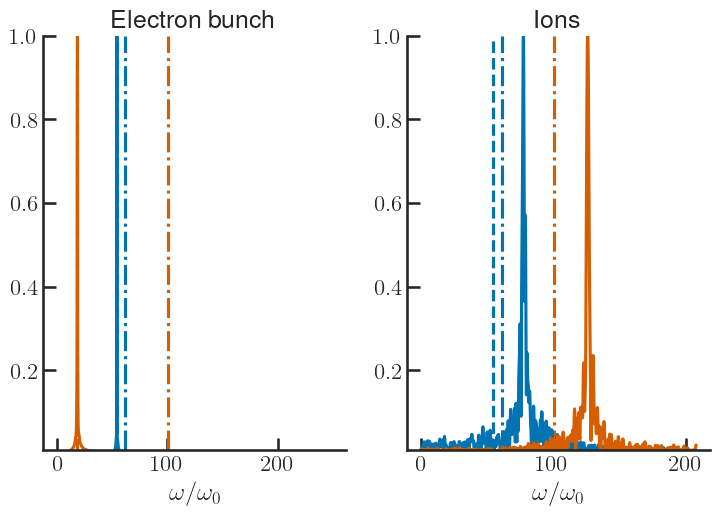

In [235]:
from numpy.fft import rfft, rfftfreq
f_0 = c/CIRCUMFERENCE
N_SEGMENTS = 500
f_s = f_0*N_SEGMENTS
fft_mean_x = np.abs(rfft(mean_x[:]-np.mean(mean_x[:])))
fft_mean_y = np.abs(rfft(mean_y[:]-np.mean(mean_y[:])))

fftfreq_mean_x = f_s*rfftfreq(mean_x[:].shape[0])/f_0
fftfreq_mean_y = f_s*rfftfreq(mean_y[:].shape[0])/f_0
f_s_ions = f_0*416
fft_mean_x_ion = np.abs(rfft(mean_x_ion[:]-np.mean(mean_x_ion[:])))
fft_mean_y_ion = np.abs(rfft(mean_y_ion[:]-np.mean(mean_y_ion[:])))

fftfreq_mean_x_ion = f_s_ions*rfftfreq(mean_x_ion[:].shape[0])/f_0
fftfreq_mean_y_ion = f_s_ions*rfftfreq(mean_y_ion[:].shape[0])/f_0
fig, (ax_el, ax_ions) = plt.subplots(1, 2)
ax_el.axvline(Q_Y, color='r', linestyle='dashed')
for ax in (ax_el, ax_ions):
    ax.axvline(Q_X, color='b', linestyle='dashed')
    ax.set_xlabel('$\omega/\omega_0$')
    ax.axvline(omega_i_x/OMEGA_REV, color='b', linestyle='dashdot')
    ax.axvline(omega_i_y/OMEGA_REV, color='r', linestyle='dashdot')
    # ax.set_ylim(1e-3, 1)
    # ax.set_xlim(10, 50)    
ax_el.plot(fftfreq_mean_x, fft_mean_x/np.max(fft_mean_x))
ax_el.plot(fftfreq_mean_y, fft_mean_y/np.max(fft_mean_y), color='r')

ax_ions.plot(fftfreq_mean_x_ion, fft_mean_x_ion/np.max(fft_mean_x_ion))
ax_ions.plot(fftfreq_mean_y_ion, fft_mean_y_ion/np.max(fft_mean_y_ion), color='r')
ax_ions.set_ylim(1e-2, 1)
ax_el.set_ylim(1e-2, 1)
# ax_el.set_xlim(18, 19)
ax_el.title.set_text('Electron bunch')
ax_ions.title.set_text('Ions')


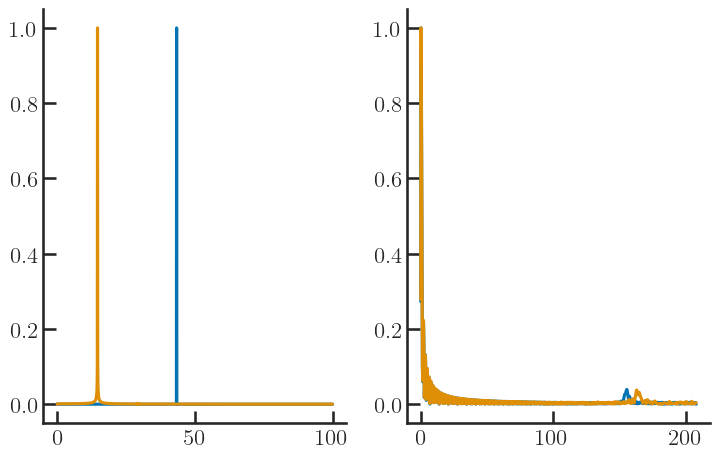

In [236]:
from numpy.fft import rfft, rfftfreq
from scipy.constants import c
CIRCUMFERENCE = 354
f_0 = c/CIRCUMFERENCE
f_s = f_0*200
fft_sigma_x = np.abs(rfft(sigma_x-np.mean(sigma_x)))
fft_sigma_y = np.abs(rfft(sigma_y-np.mean(sigma_y)))

fftfreq_sigma_x = f_s*rfftfreq(sigma_x.shape[0])/f_0
fftfreq_sigma_y = f_s*rfftfreq(sigma_y.shape[0])/f_0
f_s_ions = f_0*416
fft_sigma_x_ion = np.abs(rfft(sigma_x_ion[100:]-np.mean(sigma_x_ion)))
fft_sigma_y_ion = np.abs(rfft(sigma_y_ion[100:]-np.mean(sigma_y_ion)))

fftfreq_sigma_x_ion = f_s_ions*rfftfreq(sigma_x_ion[100:].shape[0])/f_0
fftfreq_sigma_y_ion = f_s_ions*rfftfreq(sigma_y_ion[100:].shape[0])/f_0
fig, (ax_el, ax_ions) = plt.subplots(1, 2)
ax_el.plot(fftfreq_sigma_x, fft_sigma_x/np.max(fft_sigma_x))
ax_el.plot(fftfreq_sigma_y, fft_sigma_y/np.max(fft_sigma_y))
ax_ions.plot(fftfreq_sigma_x_ion, fft_sigma_x_ion/np.max(fft_sigma_x_ion))
ax_ions.plot(fftfreq_sigma_y_ion, fft_sigma_y_ion/np.max(fft_sigma_y_ion))
# ax.axvline(Q_X*2, color='b', linestyle='dashed')
# ax.axvline(Q_Y*2, color='r', linestyle='dashed')           
# ax.axvline(2*omega_i_x/OMEGA_REV, color='b', linestyle='dashdot')
# ax.axvline(2*omega_i_y/OMEGA_REV, color='r', linestyle='dashdot')

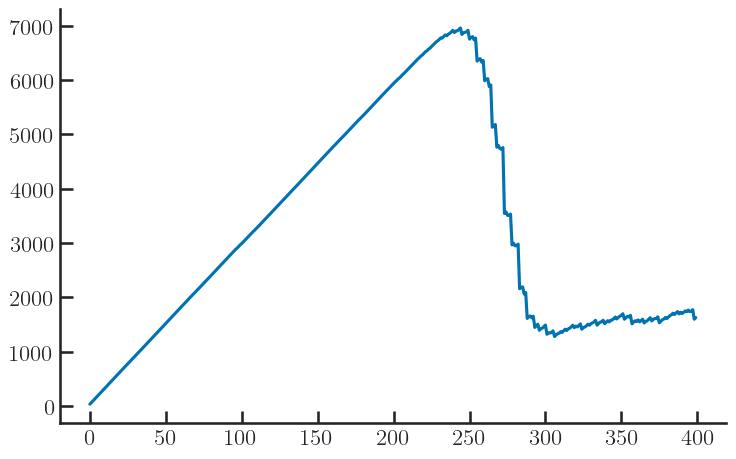

In [237]:
intensity = np.linspace(1, 400, 400)
for i in range(400):
    x, xp, y, yp, z, dp =  read_ion_particles(0, i)
    intensity[i] = x.shape[0]
fig, ax = plt.subplots(1, 1)
ax.plot(intensity)

(5937,)
(5937,)


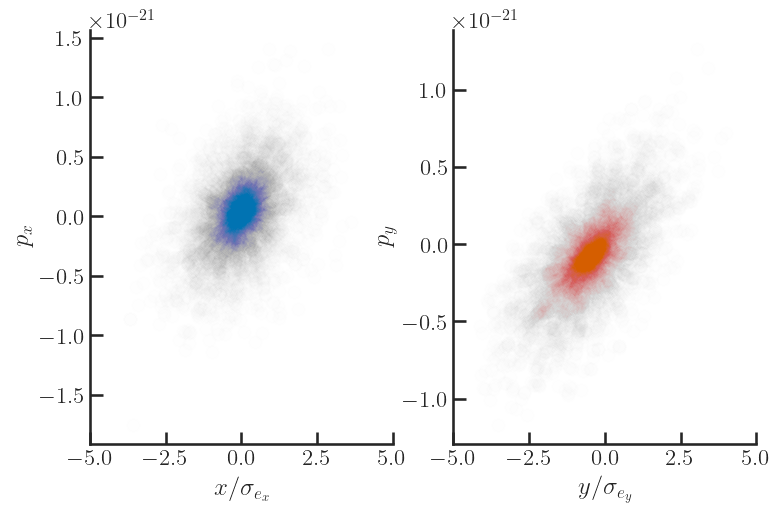

In [214]:
x, xp, y, yp, z, dp =  read_ion_particles(0, 200)
print(x.shape)
fig, axlist = plt.subplots(1, 2)
axlist[0].scatter(x/sigma_x[0], xp, alpha=0.005, color='b')
axlist[1].scatter(y/sigma_y[0], yp, alpha=0.005, color='r')
print(x.shape)
axlist[0].set_xlabel('$x/\sigma_{e_x}$')
axlist[0].set_ylabel('$p_x$')
axlist[1].set_xlabel('$y/\sigma_{e_y}$')
axlist[1].set_ylabel('$p_y$')

for ax in axlist:
    ax.set_xlim(-5, 5)
    # ax.set_ylim(-1e-21, 1e-21)
    # ax.axvline(-2)
    # ax.axvline(2)
    pass

KeyError: "Unable to open object (object 'Step#414' doesn't exist)"

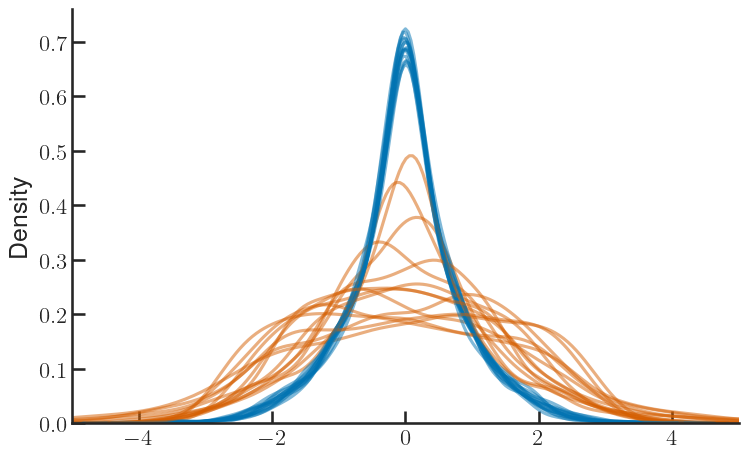

In [215]:
fig, ax = plt.subplots(1, 1)
ax.set_xlim(-5, 5)
for i in range(400, 420, 1):
    x, xp, y, yp, z, dp =  read_ion_particles(0, i)
    ax = sbs.kdeplot((x-np.mean(x))/sigma_x[0],  alpha=0.5, color='b')
    ax = sbs.kdeplot((y-np.mean(y))/sigma_y[0],  alpha=0.5, color='r')    